In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
import sys
import sklearn
import matplotlib

from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting

np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings



In [5]:
dt =  pd.read_csv('processed.cleveland.data', sep=",")
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 
              'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 
              'max_heart_rate_achieved',
               'exercise_induced_angina', 'st_depression', 'st_slope', 
              'num_major_vessels', 'thalassemia', 'target']


In [6]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'


dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'

dt['sex'] = dt['sex'].astype('object')
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object')
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')
dt['target'] = np.where(dt['target'] !=0,1, dt['target'])

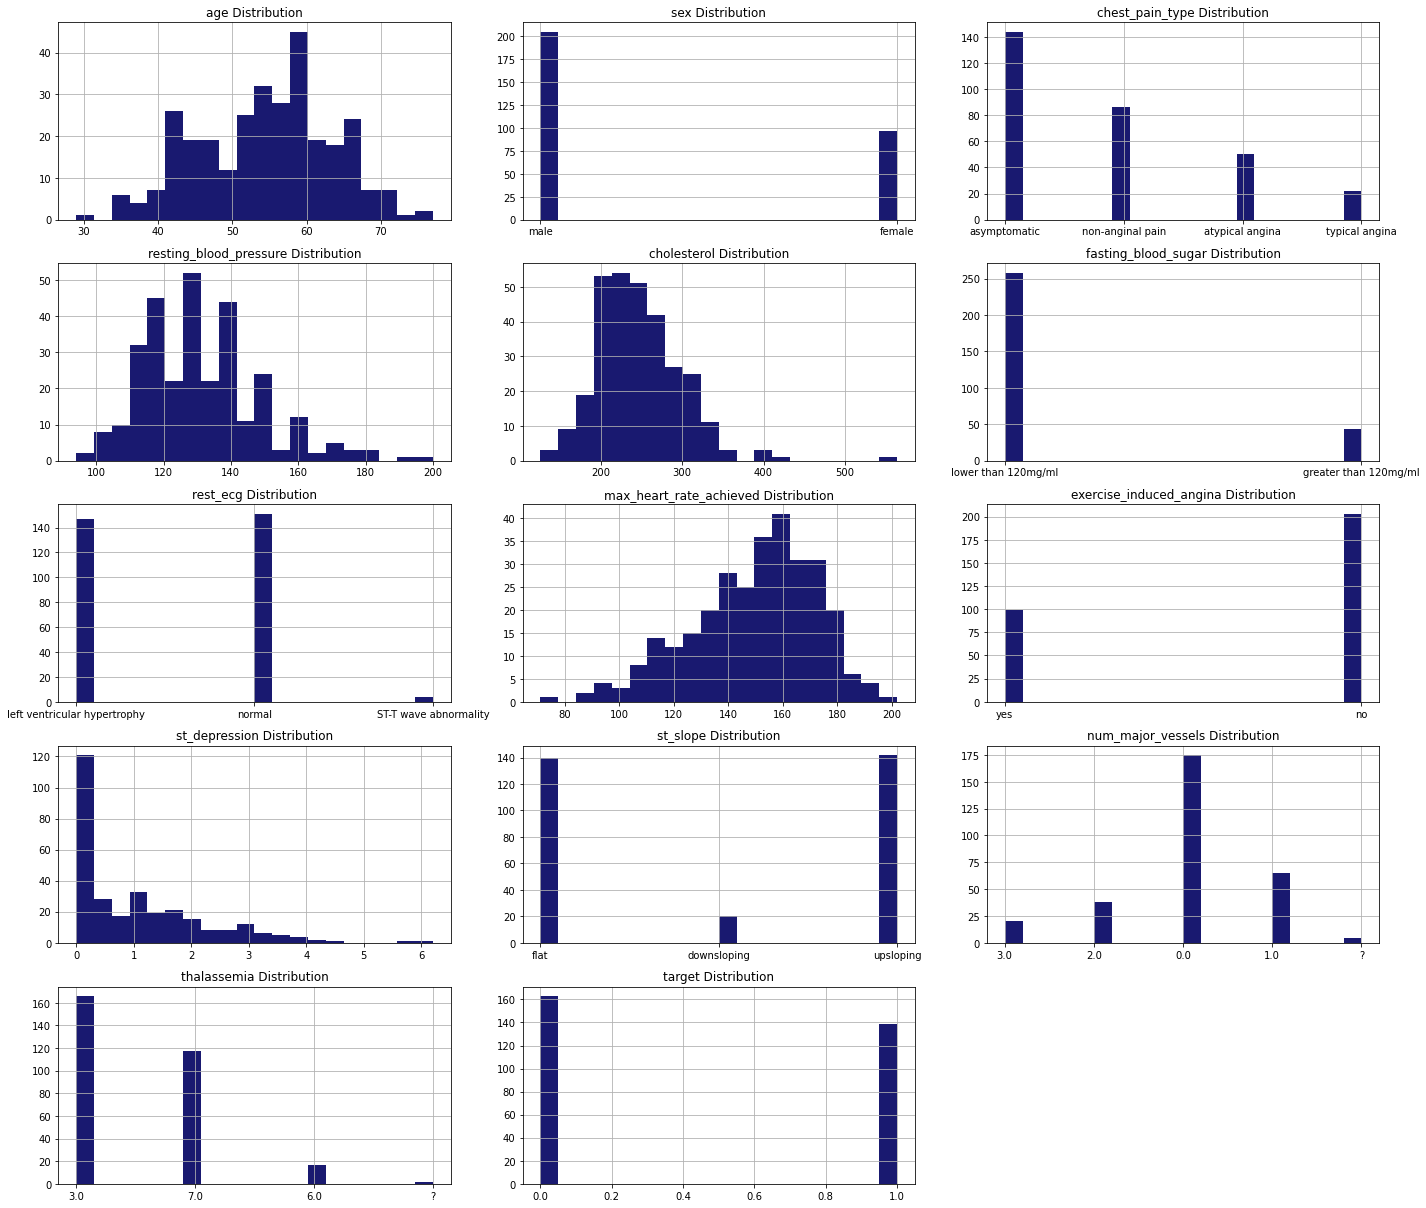

In [7]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution")
        
    fig.tight_layout()  
    plt.show()
draw_histograms(dt,dt.columns,6,3)

In [8]:
dt = pd.get_dummies(dt, drop_first=True)
dt.head()
#dt.dtypes


,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,...,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,num_major_vessels_1.0,num_major_vessels_2.0,num_major_vessels_3.0,num_major_vessels_?,thalassemia_6.0,thalassemia_7.0,thalassemia_?
0,67.0,160.0,286.0,108.0,1.5,1,1,0,0,0,...,1,1,0,0,0,1,0,0,0,0
1,67.0,120.0,229.0,129.0,2.6,1,1,0,0,0,...,1,1,0,0,1,0,0,0,1,0
2,37.0,130.0,250.0,187.0,3.5,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,41.0,130.0,204.0,172.0,1.4,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,56.0,120.0,236.0,178.0,0.8,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [9]:
#train test split
X_train, X_test, y_train,y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state = 0) 

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



/var/folders/cn/c_70xqp1153bsy_t4ckdb6jw0000gn/T/ipykernel_8747/790551325.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train,y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state = 0)


In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [9]:
#decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
tree_clf = DecisionTreeClassifier(random_state=42,max_depth=5)
tree_clf.fit(X_train, y_train)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)


Train Result:
Accuracy Score: 91.29%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.881119    0.959184  0.912863    0.920151      0.917074
recall       0.969231    0.846847  0.912863    0.908039      0.912863
f1-score     0.923077    0.899522  0.912863    0.911299      0.912228
support    130.000000  111.000000  0.912863  241.000000    241.000000
_______________________________________________
Confusion Matrix: 
 [[126   4]
 [ 17  94]]

Test Result:
Accuracy Score: 70.49%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.741935   0.666667  0.704918   0.704301      0.707386
recall      0.696970   0.714286  0.704918   0.705628      0.704918
f1-score    0.718750   0.689655  0.704918   0.704203      0.705395
support    33.000000  28.000000  0.704918  61.000000     61.000000
________

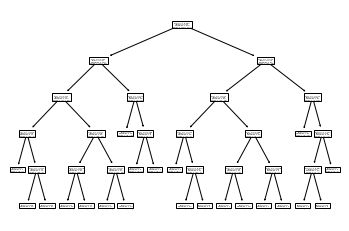

In [10]:
tree.plot_tree(tree_clf);
plt.savefig('tree_visualization.png') 

In [11]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import pydotplus
from IPython.display import Image

graph = pydotplus.graph_from_dot_data(dt) # Show graph

Image(graph.create_png()) 

ModuleNotFoundError: No module named 'graphviz'

In [12]:
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import randint
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    'max_leaf_nodes': [3, 6, 9],
}

# Create a random forest classifier
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)



# Fit the random search object to the data
rf_clf.fit(X_train, y_train)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X_train, y_train)


Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    130.0  111.0       1.0      241.0         241.0
_______________________________________________
Confusion Matrix: 
 [[130   0]
 [  0 111]]

Test Result:
Accuracy Score: 80.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.838710   0.766667  0.803279   0.802688      0.805641
recall      0.787879   0.821429  0.803279   0.804654      0.803279
f1-score    0.812500   0.793103  0.803279   0.802802      0.803597
support    33.000000  28.000000  0.803279  61.000000     61.000000
_______________________________________________
Confusion Matr

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 6, 9],
                         'n_estimators': [25, 50, 100, 150]})

In [13]:
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=6, max_features='sqrt', max_leaf_nodes=6,
                       n_estimators=50)


In [14]:
 
#linearity check
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Visual Check
# Re-run logistic regression on original set of X and y variables
from statsmodels.genmod.generalized_linear_model import GLM
logit_results = GLM(y, X, family=families.Binomial()).fit()
predicted = logit_results.predict(X)

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor continuous variable vs logit values (Age)
plt.scatter(x = dt['age'].values, y = log_odds);
plt.show()
# Confirming that there is logit linearity for the Age variable 
# (Recall earlier that p value for Age:Log Age is 0.101)
     




from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)
#f1_score(y_train, y_test)

NameError: name 'y' is not defined

In [ ]:
#check condition
#calculate Variance Inflation Factor

#feature engineering for logit regression
X=dt.drop('target', 1)
y=dt['target']
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = X.columns 
  
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
  
display(vif_scores)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
nb = GaussianNB()
nb.fit(X_train, y_train)


print_score(nb, X_train, y_train, X_test, y_test, train=True)
print_score(nb, X_train, y_train, X_test, y_test, train=False)


In [12]:
from sklearn.svm import SVC

#‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train, y_train)

print_score(svm_clf, X_train, y_train, X_test, y_test, train=True)
print_score(svm_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 87.14%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.846154    0.908163  0.871369    0.877159      0.874714
recall       0.930769    0.801802  0.871369    0.866286      0.871369
f1-score     0.886447    0.851675  0.871369    0.869061      0.870431
support    130.000000  111.000000  0.871369  241.000000    241.000000
_______________________________________________
Confusion Matrix: 
 [[121   9]
 [ 22  89]]

Test Result:
Accuracy Score: 90.16%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.935484   0.866667  0.901639   0.901075      0.903896
recall      0.878788   0.928571  0.901639   0.903680      0.901639
f1-score    0.906250   0.896552  0.901639   0.901401      0.901798
support    33.000000  28.000000  0.901639  61.000000     61.000000
________

In [ ]:
#neural netowek
import keras
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
# convert the data to categorical labels
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(y_train, num_classes=None)
Y_test = to_categorical(y_test, num_classes=None)
print (Y_train.shape)
print (Y_train[:10])
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# define a function to build the keras model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    # compile model
    adam = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

model = create_model()

print(model.summary())